In [10]:
import random
import numpy as np
from typing import List
import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from scipy.stats import ks_2samp, kstest, kurtosis
from fbm import FBM
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
from tqdm import tqdm

class SchrodingerBridge:
    def __init__(self, distSize, nbpaths, dimension, timeSeriesDataVector, kernel_type='default'):
        
        self.distSize = distSize
        self.nbpaths = nbpaths
        self.dimension = dimension
        self.timeSeriesDataVector = np.array(timeSeriesDataVector)

        self.timeSeriesVector = np.zeros((distSize + 1, dimension))
        self.timeSeriesVector[0, :] = self.timeSeriesDataVector[0, 0, :]

        self.weights = np.ones(nbpaths) / nbpaths
        self.weights_tilde = np.zeros(nbpaths)

        # Kernel selection
        if kernel_type == 'default':
            self.kernel = self.default_kernel
        elif kernel_type == 'gaussian':
            self.kernel = self.gaussian_kernel
        elif kernel_type == 'laplacian':
            self.kernel = self.laplacian_kernel
        elif kernel_type == 'polynomial':
            self.kernel = self.polynomial_kernel
        else:
            raise ValueError("Unsupported kernel type: {}".format(kernel_type))

    @staticmethod
    def default_kernel(x, H):
        return np.where(np.abs(x) < H, (H * H - x * x) ** 2, 0.0)

    @staticmethod
    def gaussian_kernel(x, H):
        return np.exp(-(x ** 2) / (2 * H ** 2)) / (np.sqrt(2 * np.pi * H ** 2))

    @staticmethod
    def laplacian_kernel(x, H):
        return np.exp(-np.abs(x) / H) / (2 * H)

    @staticmethod
    def polynomial_kernel(x, H, degree=3):
        return (1 + x / H) ** degree

    def schedule(self, timeEuler, maturity, timestep):
        time_ = np.arange(0, maturity, timestep)
        timeEuler.extend(time_)
        timeEuler.append(maturity)

    def simulate_kernel_vectorized(self, nbStepsPerDeltati, H, deltati):
        vtimestepEuler = np.arange(0, deltati + deltati / nbStepsPerDeltati, deltati / nbStepsPerDeltati)
        Brownian = np.random.normal(0, 1, (self.distSize * len(vtimestepEuler) - 1, self.dimension))

        X_ = np.zeros(self.dimension)
        index_ = 0

        for interval in tqdm(range(self.distSize), desc="Intervals"):
            if interval > 0:
                diffs = self.timeSeriesDataVector[:, interval, :] - X_
                self.weights *= self.kernel(diffs, H).prod(axis=1)

            self.weights_tilde = self.weights * np.exp(np.sum((self.timeSeriesDataVector[:, interval + 1, :] - X_) ** 2, axis=1) / (2.0 * deltati))

            for nbtime in range(len(vtimestepEuler) - 1):
                timeprev = vtimestepEuler[nbtime]
                timestep = vtimestepEuler[nbtime + 1] - vtimestepEuler[nbtime]

                exp_factors = np.exp(-np.sum((self.timeSeriesDataVector[:, interval + 1, :] - X_) ** 2, axis=1) / (2.0 * (deltati - timeprev)))
                expecX = np.dot(self.weights_tilde, exp_factors)
                numerator = np.dot(self.weights_tilde * exp_factors, self.timeSeriesDataVector[:, interval + 1, :] - X_)

                timestepsqrt = np.sqrt(timestep)
                if expecX > 0.0:
                    drift = (1.0 / (deltati - timeprev)) * (numerator / expecX)
                else:
                    drift = np.zeros(self.dimension)

                X_ += drift * timestep + Brownian[index_] * timestepsqrt
                index_ += 1

            self.timeSeriesVector[interval + 1] = X_

        return self.timeSeriesVector


## Generierung von Bildern mit Schrödinger-Brücken-Modell

In diesem Abschnitt wird der MNIST-Datensatz verwendet, um ein Schrödinger-Brücken-Modell zu trainieren und damit neue Bilder zu generieren.

### Datensatz laden und vorbereiten

Der MNIST-Datensatz wird aus TensorFlow-Keras importiert. Es werden nur die Trainingsdaten geladen, da für dieses Beispiel keine Labels benötigt werden. 

### Vorverarbeitung der Daten

Die Daten werden normalisiert, um numerische Probleme zu vermeiden. Die Pixelwerte der Bilder werden auf einen Bereich zwischen $0$ und $0.1$ skaliert und dann um $0.05$ verschoben. Die Bilder werden anschließend in eine flache Form umgewandelt, damit sie vom Schrödinger-Brücken-Modell verarbeitet werden können.

### Schrödinger-Brücken-Modell anwenden

Ein Schrödinger-Brücken-Simulator wird mit den vorverarbeiteten Bildern initialisiert. Das Modell wird verwendet, um neue Bilder zu generieren. Die Anzahl der zu generierenden Bilder wird durch die Variable `numberOfSamples` festgelegt.

### Visualisierung der generierten Bilder

Ein zufällig ausgewähltes Bild aus den generierten Bildern wird angezeigt, um die Qualität der generierten Bilder zu überprüfen.


In [2]:
from tensorflow.keras.datasets import mnist

# load dataset
(trainX, _), (_, _) = mnist.load_data()

2024-06-05 19:45:41.449113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 19:45:42.079811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
M = 10000
N = 1
NbPixels = trainX.shape[1]
deltati = 1./252.

TimeSeries = np.zeros((M, N+1, NbPixels, NbPixels))
TimeSeries[:,1,:,:] = trainX[:M,:,:]/255/10 - 0.05 # Normalization to avoid numerical issues

In [7]:
TimeSeries.min(), TimeSeries.max()

(-0.05, 0.05)

In [8]:
TimeSeriesFlat = TimeSeries.reshape(M, N+1, -1)

TimeSeriesFlat.shape

(20000, 2, 784)

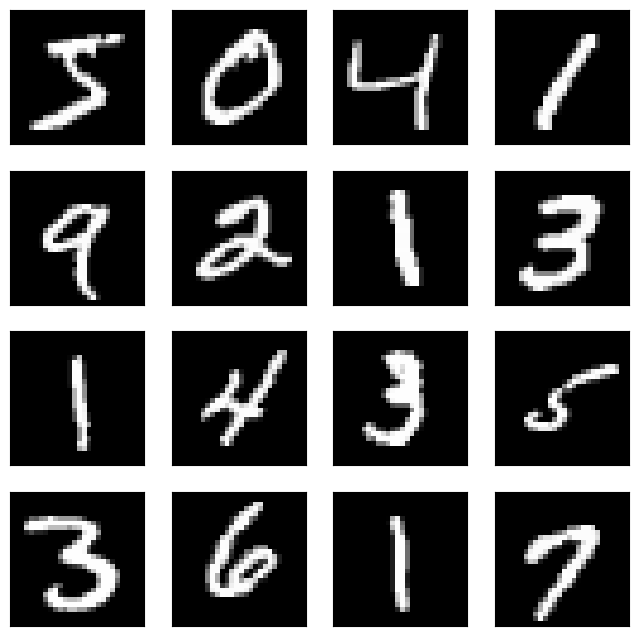

In [12]:
a= 4
b =4
fig, ax = plt.subplots(a, b, figsize=(8,8))

for i in range(a):
    for j in range(b):
        ax[i,j].imshow((TimeSeries[i*4 + j,1,:,:]+0.05)*10*255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [18]:
#Simulation

M = 10000
N = 1
NbPixels = trainX.shape[1]
deltati = 1./252.
numberOfSamples = 20 
kernel_type = 'gaussian'

TimeSeriesFlat = TimeSeries.reshape(M, N+1, -1)


simulator = SchrodingerBridge(N, M, NbPixels**2, TimeSeriesFlat, kernel_type=kernel_type)
simuTimeSeriesFlat = np.empty((numberOfSamples, N+1, NbPixels**2))
for i in tqdm(range(numberOfSamples)):
    images = np.array(simulator.simulate_kernel_vectorized(50, 1.1, 1./252.))
    simuTimeSeriesFlat[i] = images

simuTimeSeries = simuTimeSeriesFlat.reshape(numberOfSamples, N+1, NbPixels, NbPixels)

  0%|          | 0/20 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

Intervals:   0%|          | 0/1 [00:00<?, ?it/s]

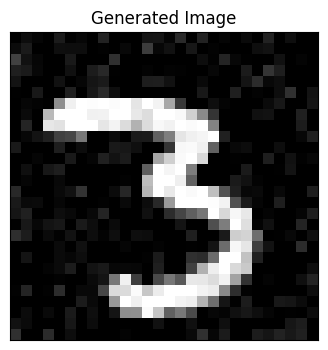

In [25]:
#Random Image

# Visualize the generated image
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
random_index = np.random.randint(0, numberOfSamples)
ax.imshow((simuTimeSeries[random_index, 1, :, :] + 0.05) * 10 * 255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Generated Image')
plt.show()

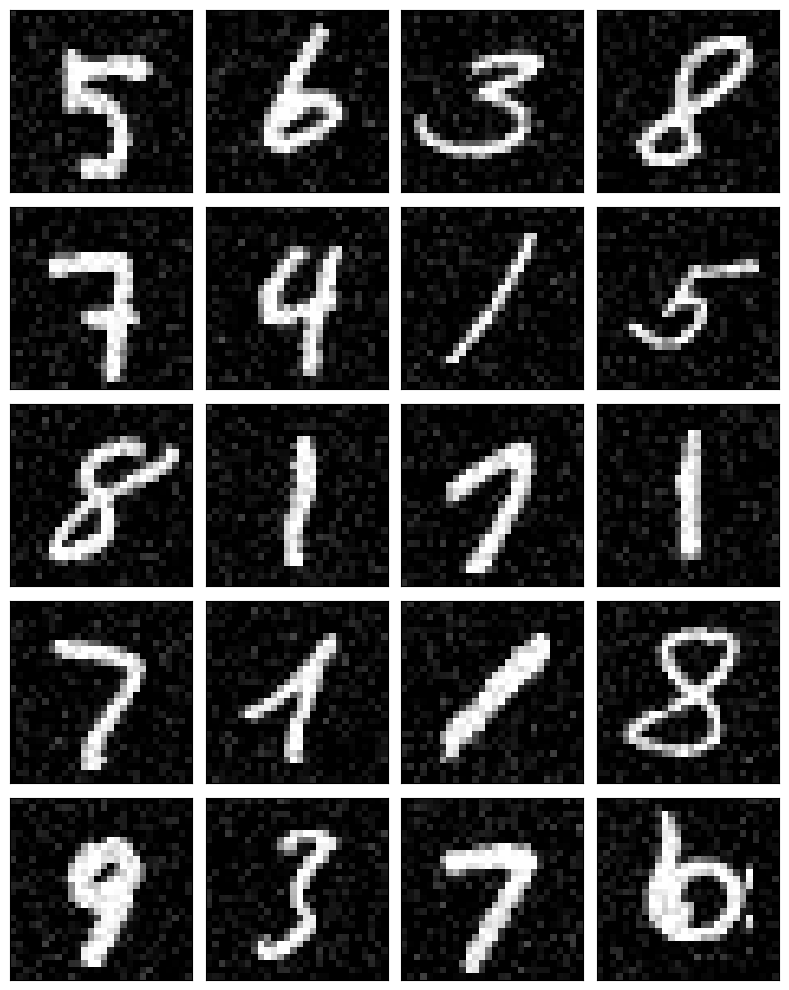

In [17]:
# Plotting all of the results
if numberOfSamples == 1:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow((simuTimeSeries[0, 1, :, :] + 0.05) * 10 * 255, cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Generated Image')
    plt.show()
else:
    rows = int(np.ceil(np.sqrt(numberOfSamples)))
    cols = int(np.ceil(numberOfSamples / rows))
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    ax = ax.flatten() if numberOfSamples > 1 else [ax]
    for i in range(numberOfSamples):
        ax[i].imshow((simuTimeSeries[i, 1, :, :] + 0.05) * 10 * 255, cmap='gray', vmin=0, vmax=255)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    for i in range(numberOfSamples, len(ax)):
        fig.delaxes(ax[i])
    plt.tight_layout()
    plt.show()

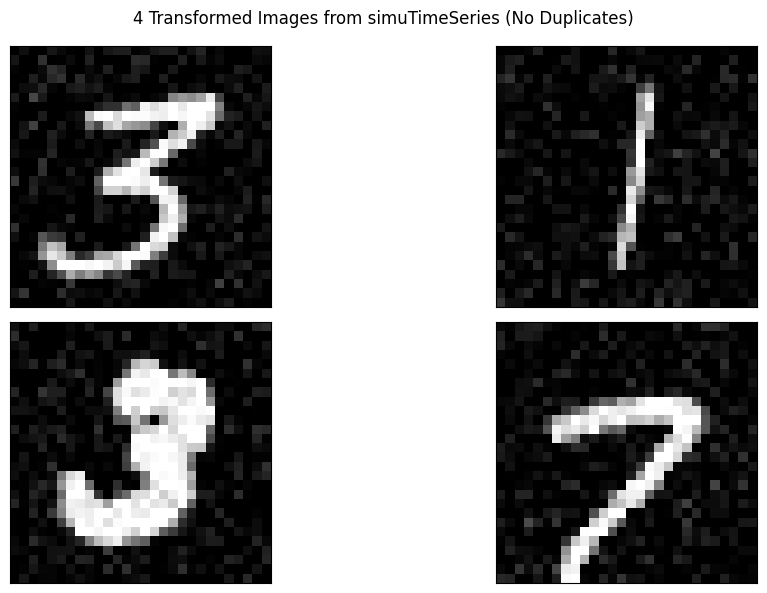

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of images to plot
number_of_images = 4  # Change this to your desired number

# Calculate the number of rows and columns for the subplot grid
rows, cols = number_of_images // 2, number_of_images % 2 or 2

# Create the figure with a suitable size
plt.figure(figsize=(12, 6 * rows / cols))  # Adjust based on desired layout

# Function to transform and plot a random image from simuTimeSeries, excluding duplicates
def plot_random_image(simuTimeSeries, used_indices, ax):
  # Keep track of used indices to avoid duplicates
  while True:
    random_index = np.random.randint(0, len(simuTimeSeries))
    if random_index not in used_indices:
      break  # Exit loop if unique index found
  used_indices.append(random_index)

  # Extract and transform the image data (assuming it's at index 1)
  image_data = (simuTimeSeries[random_index, 1, :, :] + 0.05) * 10 * 255

  # Plot the transformed image using imshow 
  ax.imshow(image_data, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

  # Remove unnecessary axis labels and ticks
  ax.set_xticks([])
  ax.set_yticks([])

# Loop to generate and plot random images (avoiding duplicates)
used_indices = []  # List to store used indices
for i in range(number_of_images):
  # Create a subplot for each image
  plt.subplot(rows, cols, i + 1)

  # Call the function to plot a random image with transformation and duplicate check
  plot_random_image(simuTimeSeries, used_indices, plt.gca())

# Add a title
plt.suptitle(f'{number_of_images} Transformed Images from simuTimeSeries (No Duplicates)', fontsize=12)

# Display the plot
plt.tight_layout()  # Adjust spacing between subplots if needed
plt.show()
